In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import sklearn
import lightgbm as lgb # LightGBM library needs to be installed to work correctly 

from sklearn import preprocessing 
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.model_selection import train_test_split

#Random forest
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report

#Decision Tree
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.tree import DecisionTreeRegressor 
from sklearn import metrics 

import catboost
from catboost import Pool
from catboost import CatBoostRegressor

from ipywidgets import interact
import ipywidgets as widgets
import warnings 

sns.set(style='white', context='talk')
plt.style.use('seaborn')
warnings.filterwarnings("ignore")
%matplotlib inline

## Importing dataset

In [2]:
def date_parser(date):
    return pd.to_datetime(date, format='%d.%m.%Y')

train = pd.read_csv('sales_train.csv', parse_dates=['date'], date_parser=date_parser)
test = pd.read_csv('test.csv')

items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
print('train:', train.shape, 'test:', test.shape, 'items:', items.shape, 'item_cats:', item_cats.shape, 'shops:', shops.shape)

train: (2935849, 6) test: (214200, 3) items: (22170, 3) item_cats: (84, 2) shops: (60, 2)


In [3]:
print('There are ',len(train),'days of record for ',train['date_block_num'].max(),' months')
train.tail()

There are  2935849 days of record for  33  months


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,2015-10-10,33,25,7409,299.0,1.0
2935845,2015-10-09,33,25,7460,299.0,1.0
2935846,2015-10-14,33,25,7459,349.0,1.0
2935847,2015-10-22,33,25,7440,299.0,1.0
2935848,2015-10-03,33,25,7460,299.0,1.0


### Category split and translation

In [4]:
item_cats['split'] = item_cats.item_category_name.str.split('-')
item_cats['category'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['subcategory'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats

,item_category_name,item_category_id,split,category,subcategory
0,PC - Гарнитуры/Наушники,0,"[PC , Гарнитуры/Наушники]",PC,Гарнитуры/Наушники
1,Аксессуары - PS2,1,"[Аксессуары , PS2]",Аксессуары,PS2
2,Аксессуары - PS3,2,"[Аксессуары , PS3]",Аксессуары,PS3
3,Аксессуары - PS4,3,"[Аксессуары , PS4]",Аксессуары,PS4
4,Аксессуары - PSP,4,"[Аксессуары , PSP]",Аксессуары,PSP
...,...,...,...,...,...
79,Служебные,79,[Служебные],Служебные,Служебные
80,Служебные - Билеты,80,"[Служебные , Билеты]",Служебные,Билеты
81,Чистые носители (шпиль),81,[Чистые носители (шпиль)],Чистые носители (шпиль),Чистые носители (шпиль)
82,Чистые носители (штучные),82,[Чистые носители (штучные)],Чистые носители (штучные),Чистые носители (штучные)


In [5]:
russian_categories = list(item_cats.category.unique())
english_categories = [
    'PC',
    'Accessories',
    'Tickets (Figure)',
    'Delivery of goods',
    'Game Consoles',
    'Games',
    'Android games',
    'MAC Games',
    'PC Games',
    'Payment cards (Cinema, Music, Games)',
    'Payment Cards',
    'Movie',
    'Books',
    'Music',
    'Presents',
    'Programs',
    'Utility',
    'Clean media (spire)',
    'Clean Media (Piece)',
    'Batteries'
]
category_translation_map = dict(zip(russian_categories, english_categories))
category_translation_map
item_cats['english_category'] = item_cats['category'].apply(lambda x: category_translation_map[x])

In [6]:
russian_subcategories = list(item_cats.subcategory.unique())
english_subcategories = [
    'Headsets / Headphones',
    'Ps2',
    'PS3',
    'Ps4',
    'PSP',
    'Psvita',
    'Xbox 360',
    'XBOX ONE',
    'Tickets (Figure)',
    'Delivery of goods',
    'Other',
    'Game Accessories',
    'Numeral',
    'Additional editions',
    'Collectible Editions',
    'Standard Editions',
    'Payment cards (Cinema, Music, Games)',
    'Live!',
    'Live! (Numeral)',
    'Psn',
    'Windows (Digit)',
    'Blu',
    'Dvd',
    'Collectible',
    'Artbooks, Encyclopedias',
    'Audiobooks',
    'Audiobooks (Digit)',
    'Audiobooks 1C',
    'Business Literature',
    'Comics, Manga',
    'Computer literature',
    'Methodical materials 1С',
    'Postcards',
    'Cognitive literature',
    'Guides',
    'Fiction',
    'Local Production CD',
    'CD brand production',
    'MP3',
    'Vinyl',
    'Music video',
    'Gift editions',
    'Attributes',
    'Gadgets, robots, sports',
    'Stuffed Toys',
    'Board games',
    'Board games (compact)',
    'Postcards, Stickers',
    'Development',
    'Certificates, services',
    'Souvenirs',
    'Souvenirs (by weight)',
    'Bags, Albums, Mousepad',
    'Figures',
    '1C: Enterprise 8',
    'MAC (Digit)',
    'Home and office',
    'Home and Office (Digital)',
    'Educational',
    'Educational (Figure)',
    'Utility',
    'Tickets',
    'Clean media (spire)',
    'Clean Media (Piece)',
    'Batteries'
]
subcategory_translation_map = dict(zip(russian_subcategories, english_subcategories))
subcategory_translation_map
item_cats['english_subcategory'] = item_cats['subcategory'].apply(lambda x: subcategory_translation_map[x])

In [7]:
print(item_cats.head())

        item_category_name  item_category_id                       split  \
0  PC - Гарнитуры/Наушники                 0  [PC ,  Гарнитуры/Наушники]   
1         Аксессуары - PS2                 1         [Аксессуары ,  PS2]   
2         Аксессуары - PS3                 2         [Аксессуары ,  PS3]   
3         Аксессуары - PS4                 3         [Аксессуары ,  PS4]   
4         Аксессуары - PSP                 4         [Аксессуары ,  PSP]   

     category         subcategory english_category    english_subcategory  
0          PC  Гарнитуры/Наушники               PC  Headsets / Headphones  
1  Аксессуары                 PS2      Accessories                    Ps2  
2  Аксессуары                 PS3      Accessories                    PS3  
3  Аксессуары                 PS4      Accessories                    Ps4  
4  Аксессуары                 PSP      Accessories                    PSP  


## Data cleaning and preparation

#### Joining data into one dataframe

In [8]:
train = pd.merge(train, shops, on='shop_id', how='left')
train = pd.merge(train, items, on='item_id', how='left')
train = pd.merge(train, item_cats, on='item_category_id', how='left')

In [9]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   date                 datetime64[ns]
 1   date_block_num       int64         
 2   shop_id              int64         
 3   item_id              int64         
 4   item_price           float64       
 5   item_cnt_day         float64       
 6   shop_name            object        
 7   item_name            object        
 8   item_category_id     int64         
 9   item_category_name   object        
 10  split                object        
 11  category             object        
 12  subcategory          object        
 13  english_category     object        
 14  english_subcategory  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(8)
memory usage: 358.4+ MB


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,split,category,subcategory,english_category,english_subcategory
0,2013-01-02,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"[Кино , Blu, Ray]",Кино,Blu,Movie,Blu
1,2013-01-03,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"[Музыка , Винил]",Музыка,Винил,Music,Vinyl
2,2013-01-05,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"[Музыка , Винил]",Музыка,Винил,Music,Vinyl
3,2013-01-06,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"[Музыка , Винил]",Музыка,Винил,Music,Vinyl
4,2013-01-15,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"[Музыка , CD фирменного производства]",Музыка,CD фирменного производства,Music,CD brand production


#### Droping duplicate data

In [10]:
print('train:', train.shape)

train.drop_duplicates(subset=['date','date_block_num','shop_id','item_id','item_cnt_day'], inplace=True)

shops_test = test.shop_id.unique()
items_test = test.item_id.unique()


train = train[train.shop_id.isin(shops_test) & train.item_id.isin(items_test) ]


print('train:', train.shape)

train: (2935849, 15)
train: (1224429, 15)


#### Checking missing data

In [11]:
train.isnull().sum()

date                   0
date_block_num         0
shop_id                0
item_id                0
item_price             0
item_cnt_day           0
shop_name              0
item_name              0
item_category_id       0
item_category_name     0
split                  0
category               0
subcategory            0
english_category       0
english_subcategory    0
dtype: int64

### Getting familier with data

In [12]:
train[['item_price', 'item_cnt_day']].describe()

,item_price,item_cnt_day
count,1.224429e+06,1.224429e+06
mean,1.030669e+03,1.321237e+00
std,1.827391e+03,3.313010e+00
min,5.000000e-01,-1.600000e+01
25%,2.990000e+02,1.000000e+00
50%,5.490000e+02,1.000000e+00
75%,1.199000e+03,1.000000e+00
max,5.920000e+04,2.169000e+03


In [13]:
train[train.item_price == train.item_price.max()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,split,category,subcategory,english_category,english_subcategory
885138,2013-09-17,8,12,11365,59200.0,1.0,Интернет-магазин ЧС,Доставка (EMS),9,Доставка товара,[Доставка товара],Доставка товара,Доставка товара,Delivery of goods,Delivery of goods


<AxesSubplot:ylabel='item_price'>

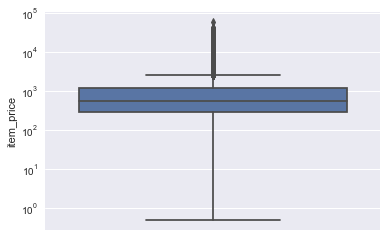

In [14]:
fig, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(y=train.item_price, whis=1.5, ax=ax)

In [15]:
train = train[~(train.item_price > 100000)]

In [16]:
train[(train.item_cnt_day > 1000)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,split,category,subcategory,english_category,english_subcategory
2909818,2015-10-28,33,12,11373,0.908714,2169.0,Интернет-магазин ЧС,Доставка до пункта выдачи (Boxberry),9,Доставка товара,[Доставка товара],Доставка товара,Доставка товара,Delivery of goods,Delivery of goods


<AxesSubplot:ylabel='item_cnt_day'>

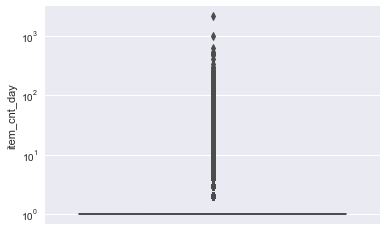

In [17]:
fig, ax = plt.subplots()
ax.set(yscale="log")
sns.boxplot(y=train.item_cnt_day, whis=1.5, ax=ax)

In [18]:
train[train.item_cnt_day < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name,split,category,subcategory,english_category,english_subcategory
1825,2013-01-02,0,25,4249,1894.87,-1.0,"Москва ТРК ""Атриум""",Kinect Star Wars [только для Kinect] [Xbox 360],23,Игры - XBOX 360,"[Игры , XBOX 360]",Игры,XBOX 360,Games,Xbox 360
5505,2013-01-14,0,25,16451,499.00,-1.0,"Москва ТРК ""Атриум""",ОБЛАЧНЫЙ АТЛАС (BD),37,Кино - Blu-Ray,"[Кино , Blu, Ray]",Кино,Blu,Movie,Blu
8499,2013-01-02,0,22,5572,1590.00,-1.0,Москва Магазин С21,PS Move Motion Controller (Контроллер движений...,2,Аксессуары - PS3,"[Аксессуары , PS3]",Аксессуары,PS3,Accessories,PS3
8974,2013-01-11,0,22,835,4600.00,-1.0,Москва Магазин С21,1С:Управление торговлей 8. Базовая версия,73,Программы - 1С:Предприятие 8,"[Программы , 1С:Предприятие 8]",Программы,1С:Предприятие 8,Programs,1C: Enterprise 8
9508,2013-01-02,0,19,3851,899.00,-1.0,"Курск ТЦ ""Пушкинский""",Heavy Rain (Essentials) (с поддержкой PS Move)...,19,Игры - PS3,"[Игры , PS3]",Игры,PS3,Games,PS3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.00,-1.0,"Москва ТРК ""Атриум""",IRON MAIDEN The Book Of Souls 2CD,55,Музыка - CD локального производства,"[Музыка , CD локального производства]",Музыка,CD локального производства,Music,Local Production CD
2934462,2015-10-18,33,25,4896,6398.00,-1.0,"Москва ТРК ""Атриум""","Mortal Kombat X. Kollector's Edition [PS4, рус...",20,Игры - PS4,"[Игры , PS4]",Игры,PS4,Games,Ps4
2935263,2015-10-05,33,25,10039,249.00,-1.0,"Москва ТРК ""Атриум""",ВОССТАНИЕ ПЛАНЕТЫ ОБЕЗЬЯН (BD),37,Кино - Blu-Ray,"[Кино , Blu, Ray]",Кино,Blu,Movie,Blu
2935643,2015-10-16,33,25,7893,2990.00,-1.0,"Москва ТРК ""Атриум""",X360: Геймпад беспроводной черный - Wireless C...,6,Аксессуары - XBOX 360,"[Аксессуары , XBOX 360]",Аксессуары,XBOX 360,Accessories,Xbox 360


In [19]:
train = train[~(train.item_cnt_day < 0)]

#### Duplicate removal

In [20]:
import difflib
shop_names = sorted(train.shop_name.unique())
seen = set()
for shop in shop_names:
    
    close_matches = frozenset(difflib.get_close_matches(shop, shop_names))
    if close_matches == {shop}:
        continue
        
    if close_matches in seen:
        continue
    print(close_matches)
    seen.add(close_matches)

frozenset({'Омск ТЦ "Мега"', 'Адыгея ТЦ "Мега"'})
frozenset({'Волжский ТЦ "Волга Молл"', 'Москва МТРЦ "Афи Молл"'})
frozenset({'Самара ТЦ "ПаркХаус"', 'Казань ТЦ "ПаркХаус" II'})
frozenset({'Волжский ТЦ "Волга Молл"', 'Москва МТРЦ "Афи Молл"', 'Москва ТРК "Атриум"'})
frozenset({'Москва ТЦ "Семеновский"', 'Москва ТК "Буденовский" (пав.К7)'})
frozenset({'Москва МТРЦ "Афи Молл"', 'Москва ТРК "Атриум"'})
frozenset({'Н.Новгород ТРЦ "Фантастика"', 'Н.Новгород ТРЦ "РИО"'})
frozenset({'Новосибирск ТРЦ "Галерея Новосибирск"', 'Новосибирск ТЦ "Мега"'})
frozenset({'Новосибирск ТРЦ "Галерея Новосибирск"', 'Омск ТЦ "Мега"', 'Новосибирск ТЦ "Мега"'})
frozenset({'Адыгея ТЦ "Мега"', 'Омск ТЦ "Мега"', 'Новосибирск ТЦ "Мега"'})
frozenset({'РостовНаДону ТЦ "Мега"', 'РостовНаДону ТРК "Мегацентр Горизонт"'})
frozenset({'РостовНаДону ТЦ "Мега"', 'Омск ТЦ "Мега"', 'РостовНаДону ТРК "Мегацентр Горизонт"'})
frozenset({'Самара ТЦ "ПаркХаус"', 'Самара ТЦ "Мелодия"'})
frozenset({'Самара ТЦ "ПаркХаус"', 'Самара ТЦ

In [21]:
# Якутск Орджоникидзе, 56 == Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
# !Якутск ТЦ "Центральный == Якутск ТЦ "Центральный
train.loc[train.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м? == Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11

## Visualization of data

### Sales plot

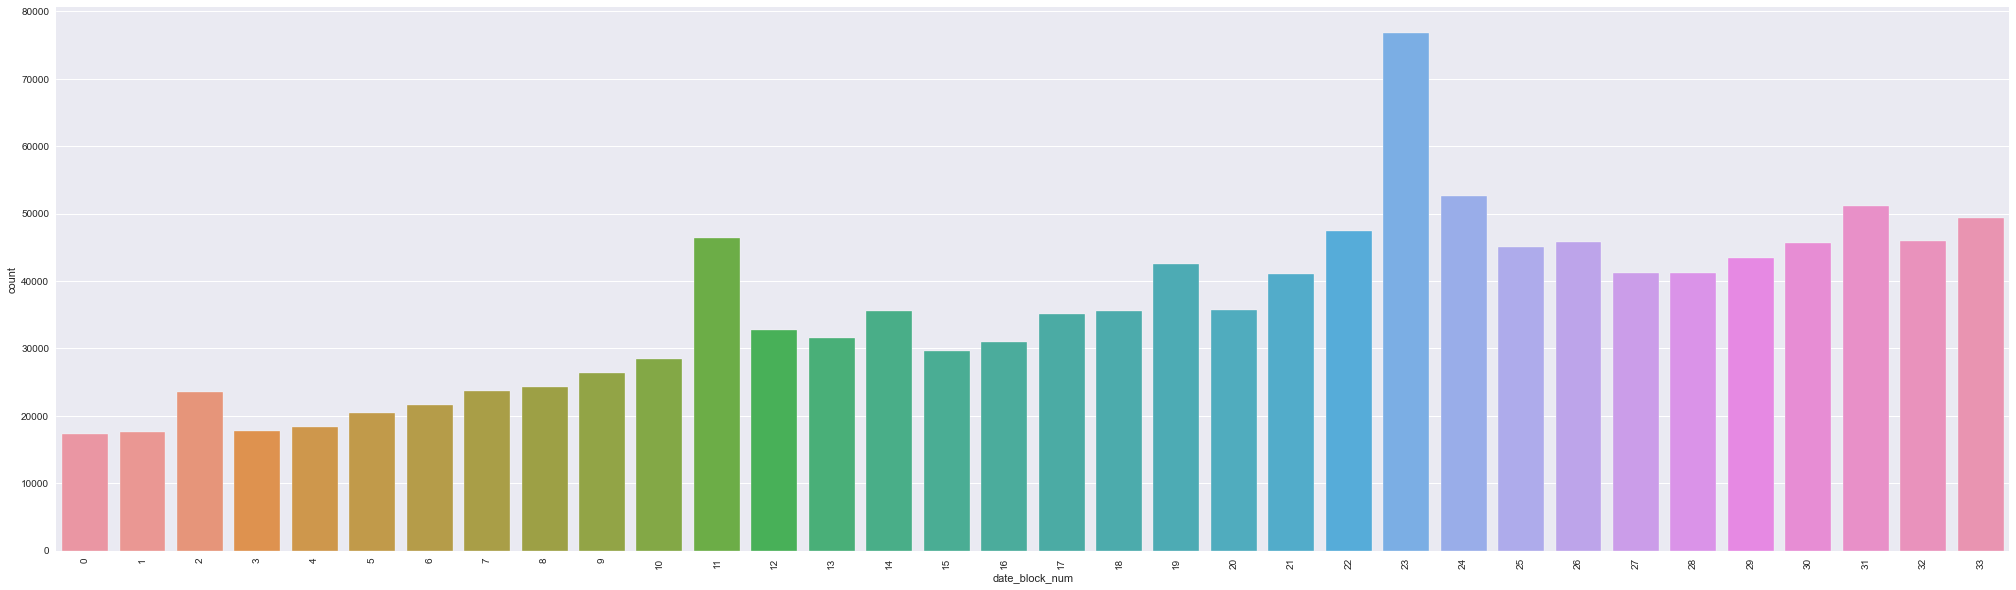

In [22]:
plt.figure(figsize=(35,10))
sns.countplot(x=train.date_block_num, data=train);
plt.xticks(rotation=90)
plt.show()

### Items per category

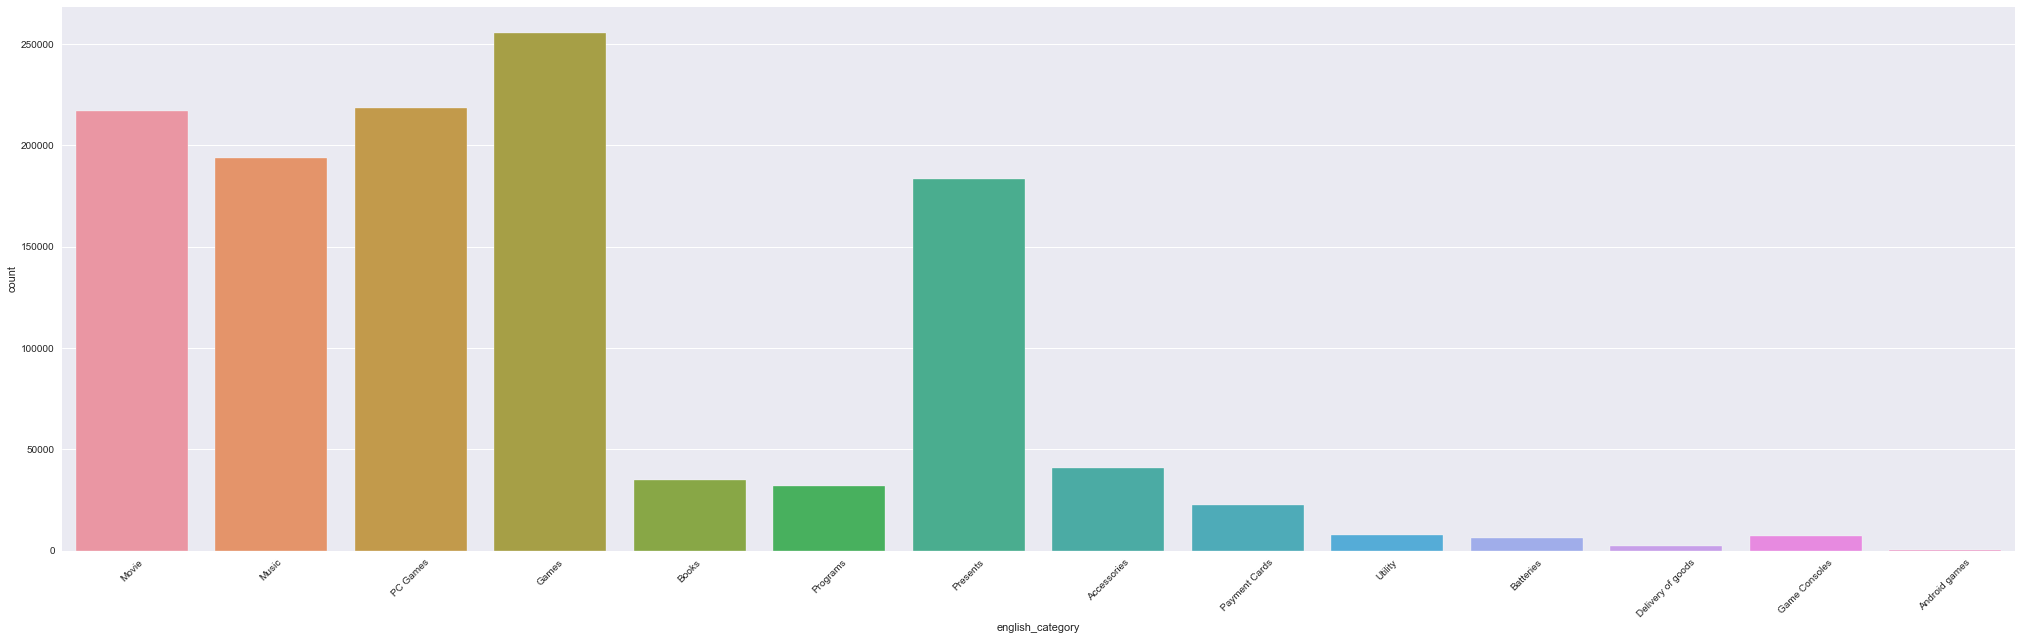

In [23]:
plt.figure(figsize=(35,10))
sns.countplot(x='english_category', data=train)
plt.xticks(rotation=45)
plt.show()

### Getting an insight on the distribution of total item_cnt_day for date_block_num

Text(0, 0.5, 'Number of sales')

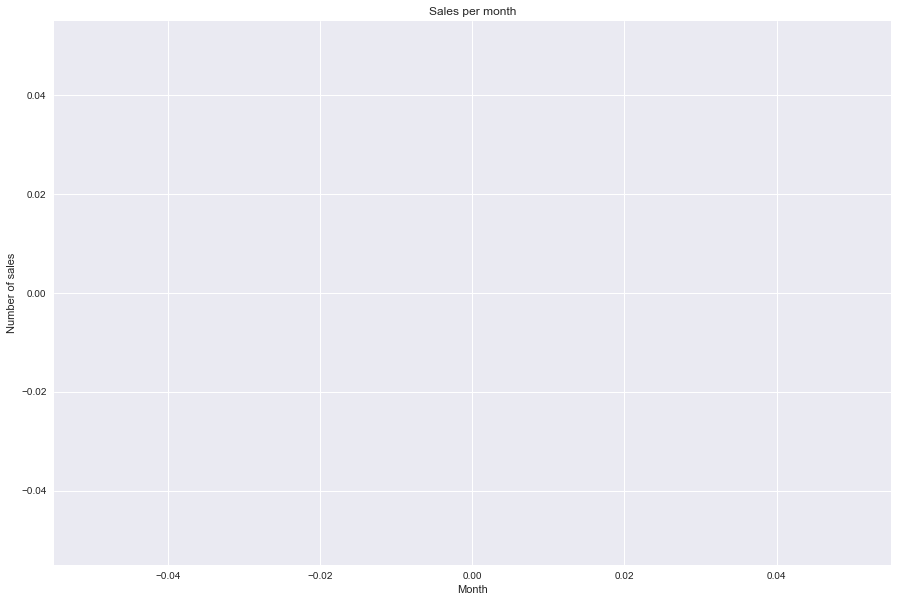

In [24]:
plt.figure(figsize = (15,10))
sns.lineplot(train.groupby('date_block_num').sum()['item_cnt_day'])
plt.title('Sales per month')
plt.xlabel('Month')
plt.ylabel('Number of sales')

Text(0.5, 1.0, 'Normalized Distiribution')

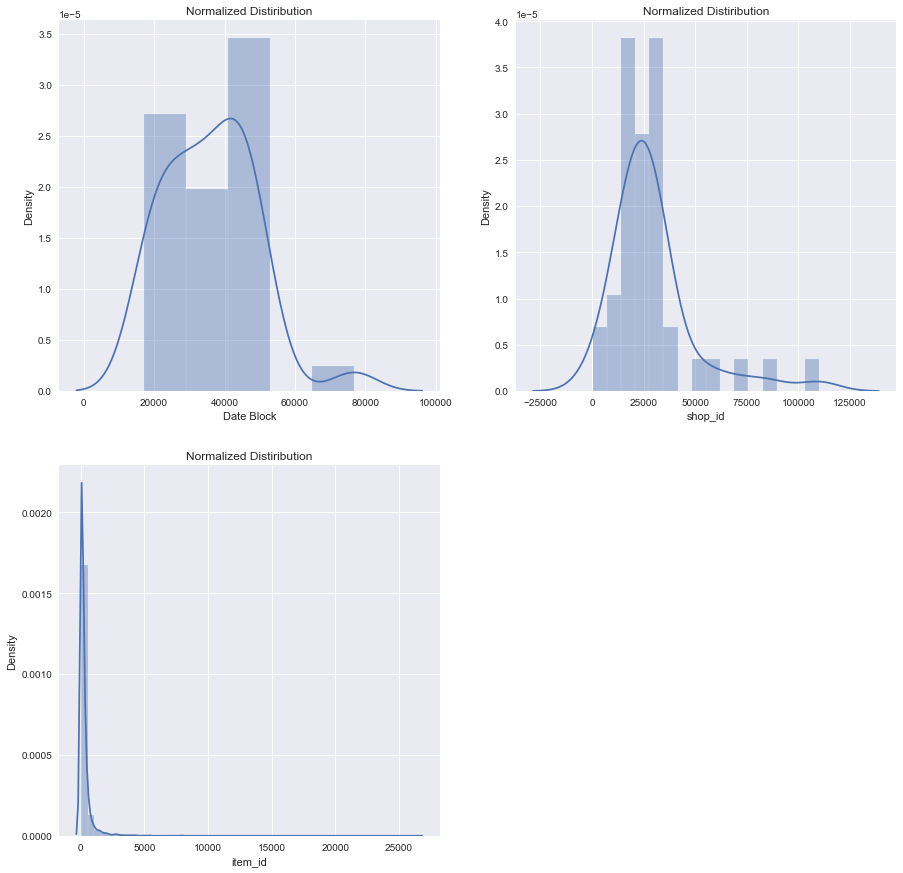

In [25]:
temp = train.date_block_num.value_counts().sort_index(ascending=False)

plt.figure(figsize = (15,15))
plt.subplot(221)
sns.distplot(temp)
plt.xlabel('Date Block');
plt.title('Normalized Distiribution')

temp = train.shop_id.value_counts().sort_index(ascending=False)
plt.subplot(222)
sns.distplot(temp)
plt.xlabel('shop_id');
plt.title('Normalized Distiribution')

temp = train.item_id.value_counts().sort_index(ascending=False)
plt.subplot(223)
sns.distplot(temp)
plt.xlabel('item_id');
plt.title('Normalized Distiribution')

## Preprocessing for Training

In [26]:
print(train.tail())
pivoted_train = train.pivot_table(index=['shop_id','item_id'], columns='date_block_num', values='item_cnt_day',aggfunc='sum').fillna(0.0)
pivoted_train.tail()
#pivoted_train['item_id']

              date  date_block_num  shop_id  item_id  item_price  \
2935844 2015-10-10              33       25     7409       299.0   
2935845 2015-10-09              33       25     7460       299.0   
2935846 2015-10-14              33       25     7459       349.0   
2935847 2015-10-22              33       25     7440       299.0   
2935848 2015-10-03              33       25     7460       299.0   

         item_cnt_day            shop_name  \
2935844           1.0  Москва ТРК "Атриум"   
2935845           1.0  Москва ТРК "Атриум"   
2935846           1.0  Москва ТРК "Атриум"   
2935847           1.0  Москва ТРК "Атриум"   
2935848           1.0  Москва ТРК "Атриум"   

                                                 item_name  item_category_id  \
2935844                   V/A Nu Jazz Selection (digipack)                55   
2935845             V/A The Golden Jazz Collection  1  2CD                55   
2935846                       V/A The Best Of The 3 Tenors                

date_block_num    0    1    2    3    4    5    6    7    8    9   ...   24  \
shop_id item_id                                                    ...        
59      22145    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22154    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22162    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22164    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0   

date_block_num    25   26   27   28   29   30   31   32   33  
shop_id item_id                                               
59      22145    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22154    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        22162    9.0  4.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  
        22164    2.0  1.0  2.0  0.0  0.0  1.0  0.0  0.0  0.0  
        22167    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

In [27]:
pivoted_train[29].describe()

count    111404.000000
mean          0.465908
std           3.154401
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         444.000000
Name: 29, dtype: float64

### Changing catagorical value into integier 

In [28]:
train_cleaned_df = pivoted_train.reset_index()
train_cleaned_df['shop_id']= train_cleaned_df.shop_id.astype('str')
train_cleaned_df['item_id']= train_cleaned_df.item_id.astype('str')

item_to_cat_df = items.merge(item_cats[['item_category_id','english_category']], how="inner", on="item_category_id")[['item_id','english_category']]
item_to_cat_df[['item_id']] = item_to_cat_df.item_id.astype('str')

train_cleaned_df = train_cleaned_df.merge(item_to_cat_df, how="inner", on="item_id")

number = preprocessing.LabelEncoder()
train_cleaned_df[['english_category']] = number.fit_transform(train_cleaned_df.english_category)
train_cleaned_df = train_cleaned_df[['shop_id', 'item_id', 'english_category'] + list(range(34))]
train_cleaned_df.head()

,shop_id,item_id,english_category,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,2,30,7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,30,7,0.0,4.0,5.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,4,30,7,0.0,7.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,30,7,0.0,5.0,7.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6,30,7,0.0,28.0,10.0,4.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [29]:
 X_train, X_test, Y_train, Y_test = train_test_split( train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values, test_size=0.30, random_state=42)

## XGBoost

In [30]:
import xgboost as xgb
param = {
        'max_depth':10, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

progress = dict()
xgbtrain = xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values, train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values)
watchlist  = [(xgbtrain,'train-rmse')]

bst = xgb.train(param, xgbtrain)
preds = bst.predict(xgb.DMatrix(train_cleaned_df.iloc[:,  (train_cleaned_df.columns != 33)].values))
from sklearn.metrics import mean_squared_error 
rmse = np.sqrt(mean_squared_error(preds,train_cleaned_df.iloc[:, train_cleaned_df.columns == 33].values))
print(rmse)

[01:23:42] WARNING: ..\src\learner.cc:541: 
Parameters: { num_round, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


1.9987214690646964


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

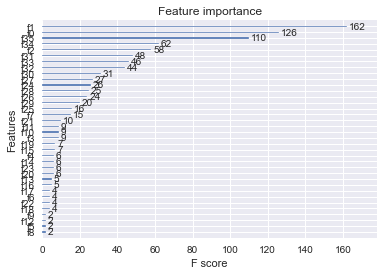

In [31]:
xgb.plot_importance(bst)

## Random Forest Classifier

In [32]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)

RandomForestClassifier()

In [33]:
preds_2 = random_forest.predict(X_test)
rmse = np.sqrt(mean_squared_error(preds_2,Y_test))
print(rmse)

12.17528390422683


In [34]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_test, preds_2))

Accuracy: 0.7681467296990007


In [35]:
from sklearn.metrics import f1_score
f1_score(Y_test,preds_2,pos_label='positive',average='micro')

0.7681467296990007

In [36]:
random_forest.feature_importances_

array([0.14240824, 0.20768684, 0.04718266, 0.00794665, 0.00871591,
       0.00889361, 0.00961651, 0.00927909, 0.00944756, 0.0089437 ,
       0.00944792, 0.01008751, 0.01022647, 0.01027712, 0.01022341,
       0.01111375, 0.0104849 , 0.01144859, 0.01347127, 0.01420931,
       0.0139204 , 0.01435788, 0.01453892, 0.01604243, 0.02112869,
       0.01960392, 0.02532359, 0.02433826, 0.02606084, 0.02528743,
       0.02917957, 0.03043439, 0.03318518, 0.03540693, 0.04429353,
       0.05578704])

## K Neighbors Classifier

In [37]:
from sklearn import neighbors
knn = neighbors.KNeighborsClassifier()
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [38]:
preds_3 = knn.predict(X_test)
rmse = np.sqrt(mean_squared_error(preds_3,Y_test))
print(rmse)

12.649182785663033


In [39]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(Y_test, preds_3))

Accuracy: 0.7329304051223745


In [47]:
from sklearn.metrics import f1_score
f1_score(Y_test,preds_3,pos_label='positive',average='micro')

0.7329304051223745

## Logistic Regression

In [41]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegression()
log_reg.fit(X_train,Y_train)

LogisticRegression()

### Logistic regression Score

In [42]:
preds_4 = log_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(preds_4,Y_test))
print(rmse)

12.851695927206405


In [43]:
print("Accuracy:",metrics.accuracy_score(Y_test, preds_4))

Accuracy: 0.7415774041050804


In [44]:
from sklearn.metrics import f1_score
print("F1 score:",f1_score(Y_test,preds_4,pos_label='positive',average='micro'))

F1 score: 0.7415774041050804
